In this notebook we implement SBL.

In [2]:
# %% Imports
import jax
from jax import lax, jit, random, numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

from flax import linen as nn
from typing import Tuple, Sequence
sns.set()

from code import fwd_solver, fixed_point_solver
from sklearn.linear_model import ARDRegression
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = jnp.load('test_data.npy', allow_pickle=True).item()
y, X = data['y'], data['X']

In [4]:
@partial(jit, static_argnums=(0,))
def fwd_solver(f, z_init, tol=1e-4):
    def cond_fun(carry):
        z_prev, z = carry
        return (
            jnp.linalg.norm(z_prev[:-1] - z[:-1]) > tol
        )  # for numerical reasons, we check the change in alpha

    def body_fun(carry):
        _, z = carry
        return z, f(z)

    init_carry = (z_init, f(z_init))
    _, z_star = lax.while_loop(cond_fun, body_fun, init_carry)
    return z_star

In [5]:
def SBL_update(prior_params, y, X, hyper_prior_params):
    # Unpacking parameters
    alpha_prev, beta_prev = prior_params[:-1], prior_params[-1]
    a, b = hyper_prior_params

    # Calculating intermediate matrices
    n_samples, n_terms = X.shape
    Sigma = jnp.linalg.inv(beta_prev * X.T @ X + jnp.diag(alpha_prev))
    mu = beta_prev * Sigma @ X.T @ y
    gamma = 1 - alpha_prev * jnp.diag(Sigma)

    # Updating
    cap = 1e6
    alpha = jnp.minimum(gamma / (mu**2).squeeze(), cap)
    beta = (n_samples - jnp.sum(gamma) + 2 * a) / (jnp.sum((y - X @ mu) ** 2) + 2 * b)
   
    return jnp.concatenate([alpha, beta[None]], axis=0), mu

In [6]:
n_samples, n_terms = X.shape
hyper_prior =  jnp.stack([n_samples / 2, 1 / (n_samples / 2 * 1e-4)],  axis=0)
prior_init = jnp.concatenate([jnp.ones((n_terms, )), jnp.ones((1, )) / jnp.var(y)], axis=0)

In [7]:
SBL_update(prior_init, y, X, hyper_prior)

(DeviceArray([1.00000000e+06, 3.39100342e+02, 1.00691696e+02,
              3.14864750e+05, 5.78766699e+03, 1.79451132e+00,
              1.72843891e+05, 1.69069250e+05, 3.71015747e+03,
              8.94845581e+00, 8.51919766e+04, 1.00000000e+06,
              4.97032013e+01], dtype=float32),
 DeviceArray([[ 0.00086446],
              [-0.05415431],
              [ 0.09961934],
              [ 0.00178211],
              [-0.01307034],
              [-0.6993269 ],
              [ 0.00238857],
              [-0.00243189],
              [ 0.01590955],
              [-0.31143987],
              [-0.00341502],
              [-0.00082254]], dtype=float32))

In [8]:
X_normed = X / jnp.linalg.norm(X, axis=0, keepdims=True)

In [9]:
update = jax.jit(lambda prior: SBL_update(prior_params=prior, y=y, X=X_normed, hyper_prior_params=hyper_prior)[0])

In [10]:
z_star = fwd_solver(update, prior_init, tol=1e-4)

In [11]:
z_star, mu = SBL_update(prior_params=z_star, y=y, X=X_normed, hyper_prior_params=hyper_prior)

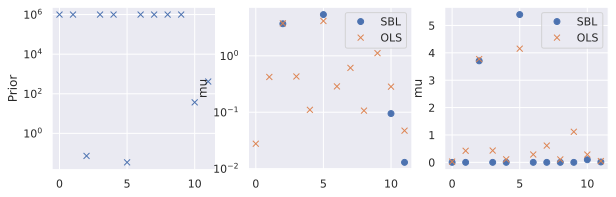

In [15]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.ylabel('Prior')
plt.semilogy(z_star[:-1], 'x')
plt.subplot(132)
plt.semilogy((z_star[:-1] < 1e4)[:, None] * jnp.abs(mu), 'o')
plt.semilogy(jnp.abs(jnp.linalg.lstsq(X_normed, y)[0]), 'x')
plt.ylabel('mu')
plt.legend(['SBL', 'OLS'])
plt.subplot(133)
plt.plot((z_star[:-1] < 1e4)[:, None] * jnp.abs(mu), 'o')
plt.plot(jnp.abs(jnp.linalg.lstsq(X_normed, y)[0]), 'x')
plt.ylabel('mu')
plt.legend(['SBL', 'OLS'])

In [13]:
reg = ARDRegression(fit_intercept=False, tol=1e-4, alpha_1=hyper_prior[0], alpha_2=hyper_prior[1])

In [14]:
reg.fit(X_normed, y.squeeze())

ARDRegression(alpha_1=DeviceArray(500., dtype=float32),
              alpha_2=DeviceArray(20., dtype=float32), fit_intercept=False,
              tol=0.0001)

In [14]:
print(jnp.concatenate([reg.coef_[:, None], (z_star[:-1] < 1e4)[:, None] * mu], axis=1))

[[ 0.0000000e+00 -0.0000000e+00]
 [-6.1026559e-04 -0.0000000e+00]
 [ 3.7052197e+00  3.7069335e+00]
 [-1.0300952e-03 -0.0000000e+00]
 [-3.2057776e-04 -0.0000000e+00]
 [-5.4015999e+00 -5.3977370e+00]
 [ 0.0000000e+00 -0.0000000e+00]
 [-5.2807648e-03 -0.0000000e+00]
 [ 0.0000000e+00 -0.0000000e+00]
 [-1.4400440e-04 -0.0000000e+00]
 [-9.1163501e-02 -9.4827786e-02]
 [-1.2100769e-02 -1.2927011e-02]]


In [15]:
print(reg.alpha_, z_star[-1])

49.87412 49.874424


In [16]:
print(jnp.stack([reg.lambda_, z_star[:-1]], axis=1))

[[4.3157695e+04 1.0000000e+06]
 [2.0163137e+03 1.0000000e+06]
 [7.2676197e-02 7.2607137e-02]
 [2.6442261e+03 1.0000000e+06]
 [4.4785200e+03 1.0000000e+06]
 [3.4244660e-02 3.4295760e-02]
 [2.4372584e+04 1.0000000e+06]
 [8.5770874e+02 1.0000000e+06]
 [1.8100182e+04 1.0000000e+06]
 [1.4968862e+03 1.0000000e+06]
 [3.8485062e+01 3.6804398e+01]
 [4.3392160e+02 4.1436649e+02]]


Now let's try it without scaling:

In [17]:
update = jax.jit(lambda prior: SBL_update(prior_params=prior, y=y, X=X, hyper_prior_params=hyper_prior)[0])
_ = update(prior_init)

In [18]:
%%time
z_star = fwd_solver(update, prior_init, tol=1e-5)

CPU times: user 483 ms, sys: 17.7 ms, total: 500 ms
Wall time: 607 ms


In [19]:
z_star, mu = SBL_update(prior_params=z_star, y=y, X=X, hyper_prior_params=hyper_prior)

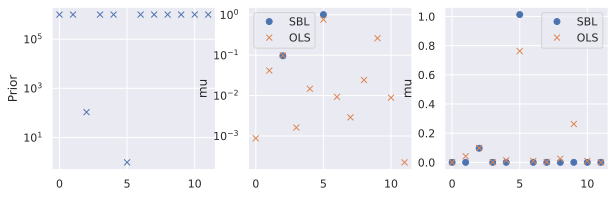

In [33]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.ylabel('Prior')
plt.semilogy(z_star[:-1], 'x')
plt.subplot(132)
plt.semilogy(jnp.abs((z_star[:-1] < 1e4)[:, None] * mu), 'o')
plt.semilogy(jnp.abs(jnp.linalg.lstsq(X, y)[0]), 'x')

plt.ylabel('mu')
plt.legend(['SBL', 'OLS'])
plt.subplot(133)
plt.plot(jnp.abs((z_star[:-1] < 1e4)[:, None] * mu), 'o')
plt.plot(jnp.abs(jnp.linalg.lstsq(X, y)[0]), 'x')
plt.ylabel('mu')
plt.legend(['SBL', 'OLS'])

Beautiful, it's correct. Now to compare with sklearn

In [21]:
reg = ARDRegression(fit_intercept=False, tol=1e-5, alpha_1=hyper_prior[0], alpha_2=hyper_prior[1], compute_score=True)

In [22]:
reg.fit(X, y.squeeze())

ARDRegression(alpha_1=DeviceArray(500., dtype=float32),
              alpha_2=DeviceArray(20., dtype=float32), compute_score=True,
              fit_intercept=False, tol=1e-05)

In [23]:
print(jnp.concatenate([reg.coef_[:, None], (z_star[:-1] < 1e4)[:, None] * mu], axis=1))

[[ 0.          0.        ]
 [ 0.         -0.        ]
 [ 0.09527698  0.09640616]
 [ 0.         -0.        ]
 [ 0.         -0.        ]
 [-0.99196243 -1.0128546 ]
 [ 0.         -0.        ]
 [ 0.         -0.        ]
 [ 0.         -0.        ]
 [ 0.         -0.        ]
 [ 0.         -0.        ]
 [ 0.         -0.        ]]


In [24]:
print(reg.alpha_, z_star[-1])

49.858635 49.861965


In [25]:
print(jnp.stack([reg.lambda_, z_star[:-1]], axis=1))

[[3.63235531e+05 1.00000000e+06]
 [1.76046914e+04 1.00000000e+06]
 [1.09958664e+02 1.07405037e+02]
 [1.93193938e+05 1.00000000e+06]
 [7.71785781e+04 1.00000000e+06]
 [1.01553035e+00 9.73536491e-01]
 [1.29094750e+05 1.00000000e+06]
 [1.26358531e+05 1.00000000e+06]
 [5.16433867e+04 1.00000000e+06]
 [1.56710391e+04 1.00000000e+06]
 [7.31293047e+04 1.00000000e+06]
 [3.73509719e+05 1.00000000e+06]]


In [34]:
from sklearn.linear_model import LassoCV

In [35]:
reg2 = LassoCV(fit_intercept=False, cv=5)

In [36]:
reg2.fit(X_normed, y.squeeze()).coef_[:, None]

array([[ 0.00811496],
       [-0.41755968],
       [ 3.7726898 ],
       [ 0.24095495],
       [-0.03002959],
       [-4.198998  ],
       [-0.        ],
       [-0.07242528],
       [-0.01286722],
       [-0.9816402 ],
       [-0.08492474],
       [-0.36541414]], dtype=float32)

So it seems to converge easier without scaling.

Let's check the grads:

In [2]:
@partial(jit, static_argnums=(0,))
def fwd_solver(f, z_init, tol=1e-4):
    def cond_fun(carry):
        z_prev, z = carry
        return (
            jnp.linalg.norm(z_prev[:-1] - z[:-1]) > tol
        )  # for numerical reasons, we check the change in alpha

    def body_fun(carry):
        _, z = carry
        return z, f(z)

    init_carry = (z_init, f(z_init))
    _, z_star = lax.while_loop(cond_fun, body_fun, init_carry)
    return z_star

In [2]:
def SBL_update(prior_params, y, X, hyper_prior_params):
    # Unpacking parameters
    alpha_prev, beta_prev = prior_params[:-1], prior_params[-1]
    a, b = hyper_prior_params

    # Calculating intermediate matrices
    n_samples, n_terms = X.shape
    Sigma = jnp.linalg.inv(beta_prev * X.T @ X + jnp.diag(alpha_prev))
    mu = beta_prev * Sigma @ X.T @ y
    gamma = 1 - alpha_prev * jnp.diag(Sigma)

    # Updating
    cap = 1e6
    alpha = jnp.minimum(gamma / (mu**2).squeeze(), cap)
    beta = (n_samples - jnp.sum(gamma) + 2 * a) / (jnp.sum((y - X @ mu) ** 2) + 2 * b)
   
    return jnp.concatenate([alpha, beta[None]], axis=0)

In [45]:
n_samples, n_terms = X.shape
hyper_prior =  jnp.stack([n_samples / 2, 1 / (n_samples / 2 * 1e-4)],  axis=0)
z_init = jnp.concatenate([jnp.ones((n_terms, )), jnp.ones((1, )) / jnp.var(y)], axis=0)

f = jax.jit(lambda prior, y, X: SBL_update(prior_params=prior, y=y, X=X, hyper_prior_params=hyper_prior))

In [72]:
z_star = fixed_point_solver(f, (y, X), z_init, 1e-5)

In [73]:
z_star[:-1, None]

DeviceArray([[1.0000000e+06],
             [1.0000000e+06],
             [1.0740495e+02],
             [1.0000000e+06],
             [1.0000000e+06],
             [9.7353560e-01],
             [1.0000000e+06],
             [1.0000000e+06],
             [1.0000000e+06],
             [1.0000000e+06],
             [1.0000000e+06],
             [1.0000000e+06]], dtype=float32)

In [48]:
jax.grad(lambda X: fixed_point_solver(f, (y, X), z_init).sum())(X)[0]

DeviceArray([-2.2079921e-06,  7.9035999e-08,  4.0764880e-04,
             -5.9022705e-07,  1.0441818e-07, -4.1141529e-03,
             -1.1307693e-06, -1.6926097e-06,  9.6654162e-08,
             -4.1987164e-08, -1.2231412e-06, -1.8530391e-06],            dtype=float32)

In [49]:
jax.grad(lambda y: fixed_point_solver(f, (y, X), z_init).sum())(y)[0]

DeviceArray([-0.0040018], dtype=float32)

now let's implement the evidence:

In [3]:
@jit
def evidence_SBL(prior_params, y, X, hyper_prior_params):
    alpha, beta = prior_params[:-1], prior_params[-1]
    a, b = hyper_prior_params

    n_samples, n_terms = X.shape
    A = jnp.diag(alpha) + beta * X.T @ X
    mn = beta * jnp.linalg.inv(A) @ X.T @ y

    E = beta * jnp.sum((y - X @ mn) ** 2) + (mn.T @ jnp.diag(alpha) @ mn).squeeze()
    loss = 0.5 * (
        jnp.sum(jnp.log(alpha))
        + n_samples * jnp.log(beta)
        - E
        - jnp.linalg.slogdet(A)[1]
    )

    # following tipping, numerically more stable if a, b -> 0 but doesn't have constant terms.
    loss += a * jnp.log(beta) - b * beta
    return loss, mn

In [5]:
loss, mn = evidence_SBL(z_star, y, X, hyper_prior)
print(loss)

NameError: name 'z_star' is not defined

In [101]:
reg.scores_

[DeviceArray(2911.3904, dtype=float32),
 DeviceArray(2939.589, dtype=float32),
 DeviceArray(2949.5269, dtype=float32),
 DeviceArray(2949.8489, dtype=float32),
 DeviceArray(2957.944, dtype=float32),
 DeviceArray(2957.9438, dtype=float32)]

Which is close enough.... Now let's put it in a layer:

In [4]:
class SparseBayesianLearning(nn.Module):
    hyper_prior: Tuple
    tol: float = 1e-4

    def setup(self):
        self.update = lambda prior, y, X: SBL_update(prior, y, X, self.hyper_prior)

    @nn.compact
    def __call__(self, inputs):
        is_initialized = self.has_variable("bayes", "z")
        z_init = self.variable(
            "bayes", "z", lambda X: jnp.concatenate([jnp.ones((X[1].shape[1], )), jnp.ones((1, )) / jnp.var(X[0])], axis=0), inputs
        )

        z_star = fixed_point_solver(
            self.update, inputs, z_init.value, tol=self.tol
        )
        
        if is_initialized:
            z_init.value = z_star
        return z_star

In [5]:
model = SparseBayesianLearning(hyper_prior, tol=1e-5)

NameError: name 'hyper_prior' is not defined

In [114]:
key = random.PRNGKey(42)
params = model.init(key, (y, X))

In [116]:
model.apply(params, (y, X), mutable=['bayes'])

(DeviceArray([1.0000000e+06, 1.0000000e+06, 1.0740495e+02, 1.0000000e+06,
              1.0000000e+06, 9.7353560e-01, 1.0000000e+06, 1.0000000e+06,
              1.0000000e+06, 1.0000000e+06, 1.0000000e+06, 1.0000000e+06,
              4.9861965e+01], dtype=float32),
 FrozenDict({
     bayes: {
         z: DeviceArray([1.0000000e+06, 1.0000000e+06, 1.0740495e+02, 1.0000000e+06,
                      1.0000000e+06, 9.7353560e-01, 1.0000000e+06, 1.0000000e+06,
                      1.0000000e+06, 1.0000000e+06, 1.0000000e+06, 1.0000000e+06,
                      4.9861965e+01], dtype=float32),
     },
 }))

Okay so that works too! Now to put in a nice model

In [6]:
from code import create_update
from modax.data.burgers import burgers
from modax.feature_generators import library_backward
from modax.networks import MLP
from flax import optim
from modax.losses import neg_LL
from modax.logging import Logger

In [7]:
def loss_fn_SBL(params, state, model, x, y):
    """ first argument should always be params!
    """
    variables = {'params': params, **state}
    (prediction, dt, theta, z), updated_state = model.apply(variables, x, mutable=list(state.keys()))
    
    
    # MSE
    sigma_ml = jnp.mean((prediction - y) ** 2)
    tau = 1 / sigma_ml
    MSE = neg_LL(prediction, y, tau)
    
    # Reg
    Reg, mn = evidence_SBL(z, dt, theta, model.hyper_prior)
    loss = MSE - Reg
    metrics = {
        "loss": loss,
        "mse": MSE,
        "reg": Reg,
        "coeff": mn,
        "tau": tau, 
        "beta": z[-1],
        "alpha": z[:-1]
    }
    return loss, (updated_state, metrics)

In [8]:
class Deepmod(nn.Module):
    features: Sequence[int]
    hyper_prior: Tuple
    tol: float = 1e-5

    @nn.compact
    def __call__(self, inputs):
        prediction, dt, theta = library_backward(MLP(self.features), inputs)
        z = SparseBayesianLearning(self.hyper_prior, self.tol)((dt, theta))
        return prediction, dt, theta, z

In [9]:
key = random.PRNGKey(42)

In [10]:
# Making dataset
x = jnp.linspace(-3, 4, 50)
t = jnp.linspace(0.5, 5.0, 20)

t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
u = burgers(x_grid, t_grid, 0.1, 1.0)

X_train = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_train = u.reshape(-1, 1)
y_train += 0.01 * jnp.std(y_train) * jax.random.normal(key, y_train.shape)

In [11]:
n_samples = X_train.shape[0]
hyper_prior =  jnp.stack([n_samples / 2, 1 / (n_samples / 2 * 1e-4)],  axis=0)
model = Deepmod([50, 50, 1], hyper_prior, tol=1e-5)

In [12]:
key_network, _ = random.split(key)

In [ ]:
variables = model.init(key_network, X_train)

In [ ]:



optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop('params')
optimizer = optimizer.create(params)

In [ ]:
# Compiling train step
update = create_update(loss_fn_SBL, model=model, x=X_train, y=y_train)
_ = update(optimizer, state)  # triggering compilation

In [143]:
# Running to convergence
max_epochs = 10000
logger = Logger()
for epoch in jnp.arange(max_epochs):
    (optimizer, state), metrics = update(optimizer, state)
    if epoch % 1000 == 0:
        print(f"Loss step {epoch}: {metrics['loss']}")
    if epoch % 25 == 0:
        logger.write(metrics, epoch)
logger.close()

Loss step 0: -2167.581298828125
Loss step 1000: -7402.24755859375
Loss step 2000: -7650.0205078125
Loss step 3000: -7682.76025390625
Loss step 4000: -7707.0830078125
Loss step 5000: -7714.4482421875
Loss step 6000: -7703.1513671875
Loss step 7000: -7727.21875
Loss step 8000: -7760.638671875
Loss step 9000: -7747.9931640625
